#### Initialising default font sizes for matplotlib figures

In [56]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Exploration

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, parser='auto', as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

the dataset thus comprises of 70k images where each image has 784 features. This is because each image is 28x28 pixels and each feature represents one pixel's intensity from 0(white) to 255(black).

In [4]:
mnist.DESCR

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

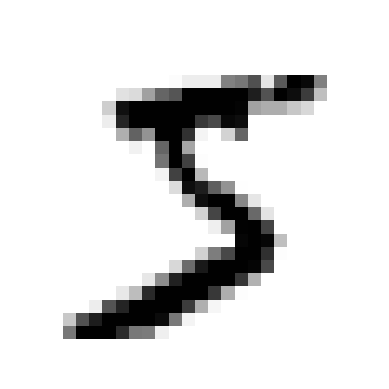

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
y[59] # confirming the label of image

'1'

In [7]:
import numpy as np
y = y.astype(np.uint8) # casting labels to integers instead of strings

In [8]:
# Splitting dataset into train and test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# It is advisable to shuffle a dataset as some algos are sensitive to the order of training instances.

## Binary Classifier(5 or not 5)

In [9]:
y_train_5 = (y_train == 5) # creates a boolean array of True if 5, else False
y_test_5 = (y_test == 5)
y_train_5

array([ True, False, False, ...,  True, False, False])

In [10]:
from sklearn.linear_model import SGDClassifier
# importing Stochastic Gradient Descent Classifier which can handle large datasets efficiently
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict(X)[0] # successfully predicts the number in the first image of dataset

True

## Performance Measures
These are significantly more complex when it comes to classification tasks as compared to regressional ones.

### Implementing Cross-validation
Doing this to get more control over the CV process than pre built functions.

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)
# does roughly the same work as sklearn's cross_val_score()
for i, (train_index, test_index) in enumerate(skfolds.split(X_train, y_train_5)):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    print(f"Fold {i}")
    print(f"Train index: {train_index}")
    print(f"Test index: {test_index}")

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

Fold 0
Train index: [19964 19965 19966 ... 59997 59998 59999]
Test index: [    0     1     2 ... 20331 20342 20359]
0.95035
Fold 1
Train index: [    0     1     2 ... 59997 59998 59999]
Test index: [19964 19965 19966 ... 40088 40125 40127]
0.96035
Fold 2
Train index: [    0     1     2 ... 40088 40125 40127]
Test index: [39988 39989 39990 ... 59997 59998 59999]
0.9604


In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

93% accuracy on all folds? wao but look at a dumbass classifier which classifies every single image as `not 5` class

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

What's this? this dumbass scores 90+% as well? This is because only about 10% of the images in this dataset are of 5s, so yeah you will be right 90% of the time regardless. 

This is why accuracy is generally not the preferred performance measure for classifiers, when you are dealing with _skewed_ datasets(minority class is much too minor)

### Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at the confu‐
sion matrix. The general idea is to count the number of times instances of class A are
classified as class B. For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion
matrix.

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column repre‐
sents a predicted class. The first row of this matrix considers non-5 images (the nega‐
tive class): 53,057 of them were correctly classified as non-5s (they are called true
negatives), while the remaining 1,522 were wrongly classified as 5s (false positives).
The second row considers the images of 5s (the positive class): 1,325 were wrongly
classified as non-5s (false negatives), while the remaining 4,096 were correctly classi‐
fied as 5s (true positives). A perfect classifier would have only true positives and true
negatives, so its confusion matrix would have nonzero values only on its main diago‐
nal (top left to bottom right):

In [18]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision and Recall

In [19]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Not so shiny results this time huh. Both precision and recall are slightly inverse in proportionality to each other in most cases- turn one up and the other will go down by itself, this is the precision-recall tradeoff.
Precision is thus used in conjunction with recall and there is an even better alternative which is

### F1 score
This is the harmonic mean of precision and recall both, the harmonic mean gives much more weight to low values, as a result of which the classifier will only get a high F1 score if both params are high

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred) # This metric favors classifiers which have similar precision and recall

0.7325171197343846

The situation in the comment in the preceding cell is not always what we want:  in some contexts you mostly care about precision, and in other con‐
texts you really care about recall. For example, if you trained a classifier to detect vid‐
eos that are safe for kids, you would probably prefer a classifier that rejects many
good videos (low recall) but keeps only safe ones (high precision), rather than a clas‐
sifier that has a much higher recall but lets a few really bad videos show up in your
product (in such cases, you may even want to add a human pipeline to check the clas‐
sifier’s video selection). On the other hand, suppose you train a classifier to detect
shoplifters on surveillance images: it is probably fine if your classifier has only 30%
precision as long as it has 99% recall (sure, the security guards will get a few false
alerts, but almost all shoplifters will get caught).


### Precision-Recall tradeoff(and curve)

In [22]:
y_scores = sgd_clf.decision_function(X)[0]
y_scores

2164.2203023926586

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

True

In [24]:
# raising the threshold for SGDClassifier now to change the result
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

False

In [25]:
# To decide which threshold to use, get scores of all instances in training set using cross_val_predict(), but specifying that it returns decision scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [39]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

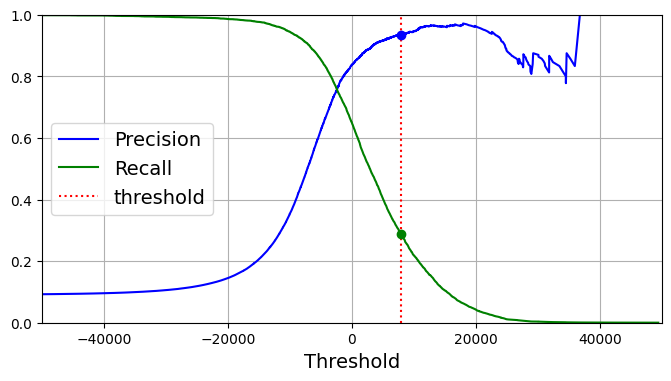

In [27]:
index = (thresholds >= threshold).argmax() # first score that exceeds or equals the set threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8,4))
    plt.plot(thresholds, precisions[:-1], "b-", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.vlines(threshold, 0, 1.0, "r", "dotted", label="threshold")
    plt.axis([-50000, 50000, 0, 1])
    plt.legend(loc="center left")
    plt.grid()
    plt.plot(thresholds[index], precisions[index], "bo") # use blue marker to point out the threshold using `bo`
    plt.plot(thresholds[index], recalls[index], "go")
    plt.xlabel("Threshold")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another way to select a good precision/ recall trade-off is by plotting a Precision-Recall curve.

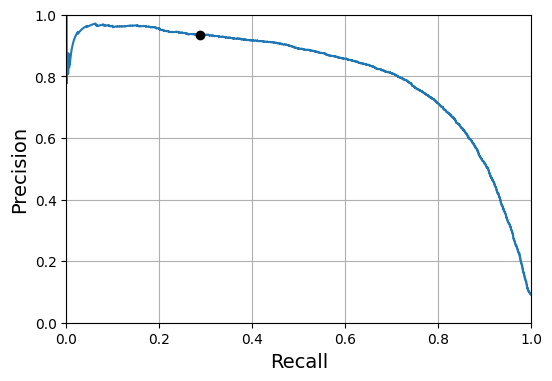

In [36]:
plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, label="Precision/Recall curve")
plt.plot([recalls[index]], [precisions[index]], "ko", label="Point at 8k threshold") # i am messing up smth here. it is supposed to land bw 0.4 and 0.6
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.axis([0, 1, 0, 1])
plt.show()

The precision starts to fall off sharply at around 80% recall. Select a proper P/R tradeoff just before this drop- like at 60% recall here. 

If one is aiming for 90% precision, then he can find the required threshold in the first plot(which is 8k). Or you can also find the lowest threshold that gives us 90% precision. (`np.argmax` will give the first index of the maximum value, which is the first `True` value here)

In [40]:
threshold_90_precision = thresholds[(precisions >= 0.90).argmax()]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [37]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [31]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Always take recall in account when someone is talking about their precision and vice versa

### ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another namefor recall) against the false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called `specificity`. Hence the ROC curve plots `sensitivity (recall)` versus `1 – specificity`

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

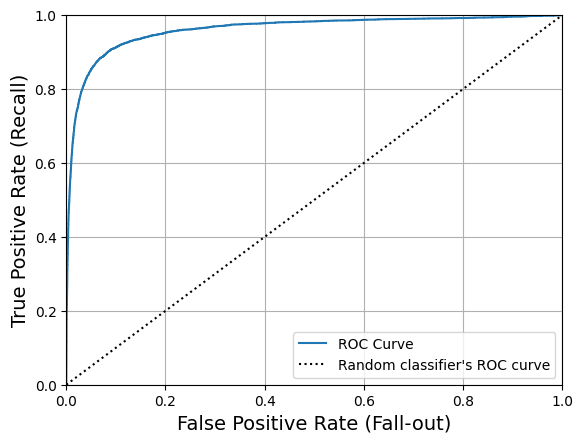

In [77]:
def plot_roc_curve(fpr, tpr, thresholds, label = None):
    #plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=label)
    plt.grid()
    idx_for_threshold_at_90 = (thresholds <= threshold_90_precision).argmax()
    plt.axis([0, 1, 0, 1])
    tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
    #plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
    plt.xlabel("False Positive Rate (Fall-out)")
    plt.ylabel("True Positive Rate (Recall)")
    #plt.legend(loc="lower right")

plot_roc_curve(fpr, tpr, thresholds, "ROC Curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.legend()
plt.show()

In [59]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

The score is pretty good! But one crucial thing to note about this is that you should prefer `PR curve` whenever the positive class is rare(5 here) or when you care more about the False Positives more than False Negatives, and use `ROC curve` otherwise.

The classifier might appear to be great with such an Area under ROC curve, but the positive class is very rare in this dataset(10% are 5s)compared to the negative class(not 5). In contrast, the PR curve makes matters more clear by pointing out that the curve could be more towards the top right corner and can do better.

#### Comparing ROC curves
Let's pick up a Random Forest classifier and compare its ROC curve with the SGDClassifier that we are using.
The RandomForestClassifier does not have a decision_function() method but a predict_proba() method which returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class.

In [60]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probabs_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                     method="predict_proba")

In [62]:
y_probabs_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [65]:
y_scores_forest = y_probabs_forest[:, 1] # stores the probabilities for positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

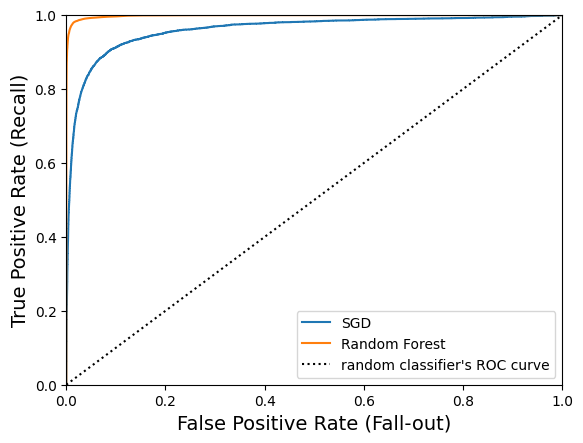

In [78]:
plot_roc_curve(fpr, tpr, thresholds, "SGD")
plot_roc_curve(fpr_forest, tpr_forest, thresholds_forest, "Random Forest")
plt.plot([0, 1], [0, 1], "k:", label="random classifier's ROC curve")
plt.legend(loc="lower right")
plt.show()

In [79]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [83]:
# Returns precisions, recalls and their respective thresholds for RF classifier
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)
# Searching for the threshold which takes the precision above 90%
threshold_90_precision_forest = thresholds_forest[(precisions_forest >= 0.90).argmax()]
y_train_pred_90_forest = (y_scores_forest >= threshold_90_precision_forest)

print("Precision: ", precision_score(y_train_5, y_train_pred_90_forest), " Recall: ", recall_score(y_train_5, y_train_pred_90_forest))

Precision:  0.9020883259157823  Recall:  0.9721453606345692


In [85]:
# alternative
y_train_pred_forest = y_probabs_forest[:, 1] >= 0.5  # positive proba ≥ 50%

print("Precision: ", precision_score(y_train_5, y_train_pred_forest), " Recall: ", recall_score(y_train_5, y_train_pred_forest)) 

Precision:  0.9897468089558485  Recall:  0.8725327430363402


## Multiclass Classification
Multiclass / Multinomial Classifiers can distinguish between more than two classes.

One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the **one-versus-all (OvA)** strategy (also called one-versus-the-rest).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the **one-versus-one (OvO) strategy**. If there are N classes, you need to train N × (N – 1) / 2 classifiers. This means a total of 45 classifiers for this particular data.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO).

In [89]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5

SGDClassifier(random_state=42)

In [92]:
some_digit = X[0]
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [93]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

The highest score is corresponding to class 3.

In [94]:
np.argmax(some_digit_scores)

3

In [97]:
# the classifier stores a list of classes 
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

To force sklearn to choose between `OneVsRestClassifier(OvA)` or `OneVsOneClassifier(OvO)`, you can import any of these classes. Then, create an instance and pass the binary classifier to its constructor. For ex.

In [98]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [100]:
len(ovo_clf.estimators_) # total classifiers

45

Training Random Forest as a multiclass model is even easier, just fit it and sklearn won't run either OvA or OvO on it as RF classifiers can directly classify instances into multiple classes.

In [101]:
forest_clf.fit(X_train, y_train) # not y_train_5 this time, we are making a multiclass classifier

RandomForestClassifier(random_state=42)

In [102]:
forest_clf.predict([some_digit])

array([5], dtype=uint8)

RF successfully predicted the right class for the instance that Stochastic Gradient Descent classifier was messing up.

In [104]:
forest_clf.predict_proba([some_digit]) # shows the probabilities of a certain instance belonging to that particular class for all classes

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [107]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Not bad not bad, let's scale the inputs to make it even better!

In [108]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [109]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [110]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

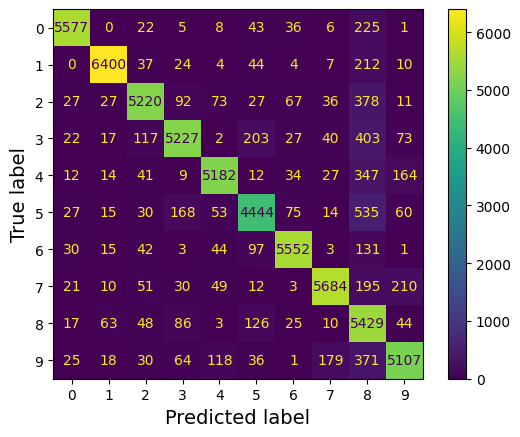

In [120]:
from sklearn.metrics import ConfusionMatrixDisplay
# much better for visualisation tbh
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

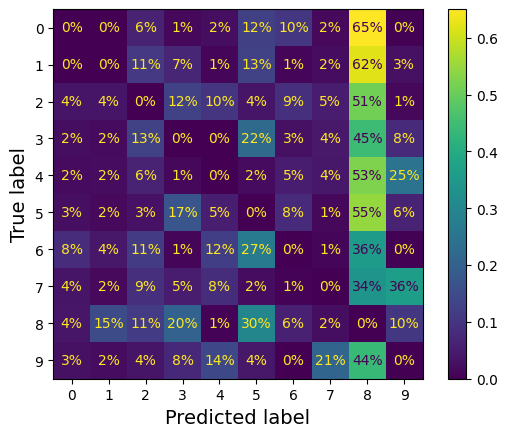

In [122]:
sample_weight = (y_train_pred != y_train) # adding weights towards error rate
plt.rc('font', size=10) 
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

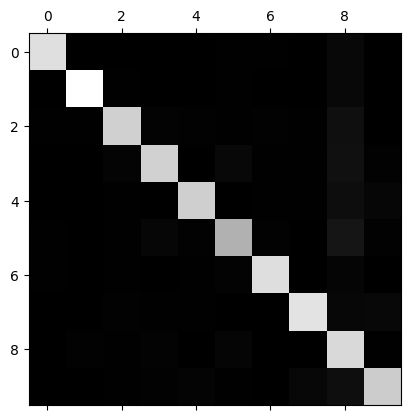

In [111]:
plt.matshow(conf_matrix, cmap=plt.cm.gray)
plt.show()

The images are mostly well aligned with the main diagonal, which is good as they were classified correctly. 5s look darker than others because it might not have many instances in the dataset or the model might not be predicting 5s as nicely as it does with other classes(Both cases are true here).

We are focusing on the errors now, divide each value by the number of images in the corresponding class, so we can compare error rates instead of the absolute number of errors (which make abundant classes appear unfairly bad). 

In [112]:
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums

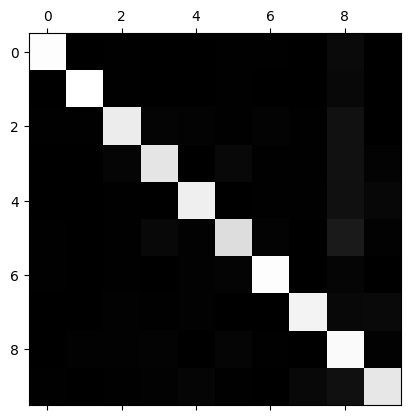

In [114]:
plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)

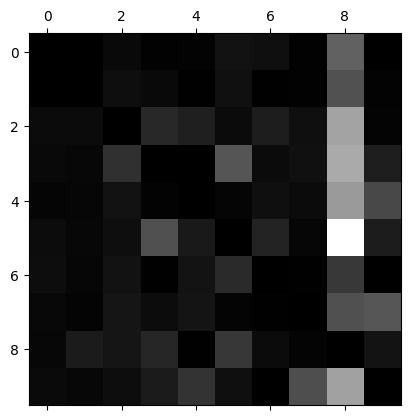

In [118]:
# Filling the main diagonal with 0s to only show the error rates
np.fill_diagonal(norm_conf_matrix, 0)
plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)
plt.show()

The rows represent the actual classes, while the columns show the predicted classes. The column for class 8 is quite bright, which implies that many numbers get frequently mistaken as 8s- though ironically the actual row for 8 is not bad at all, thus implying that actual 8s get properly classified as 8s. 

Looking at this plot, it is quite clear that our efforts should be spent on reducing the number of false 8s. For example, you could try to gather more training data for digits that look like 8s (but are not) so the classifier can learn to distinguish them from real 8s.
Or you could engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops.

In [123]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

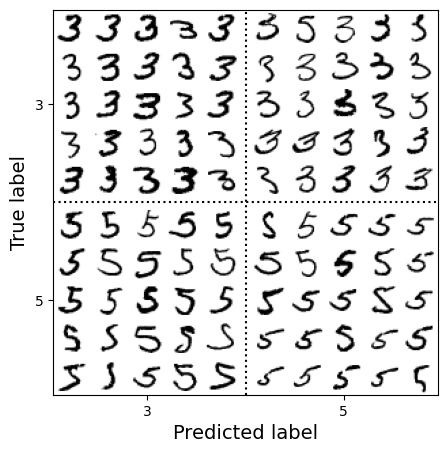

In [125]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

Going to understand this code when I feel more creative. just copy paste for now.

The two 5×5 blocks on the left show digits classified as 3s, and the two 5×5 blocks on the right show images classified as 5s. Some of the digits that the classifier gets wrong (i.e., in the bottom-left and top-right blocks) are so badly written that even a human would have trouble classifying them (e.g., the 5 on the 1st row and 2nd column truly looks like a badly written 3). However, most misclassified images seem like obvious errors to us, and it’s hard to understand why the classifier made the mistakes it did. The reason is that we used a simple SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them

## Multilabel Classification

In some cases you may want your classifier to output multiple classes for each instance. For example, consider a face-recognition classifier: what should it do if it recognizes several people on the same picture? Of course it should attach one tag per person it recognizes. Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then when it is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple binary tags is called a multilabel classification system.

In [128]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [127]:
knn_clf.predict([some_digit])

array([[False,  True]])

The digit is indeed not large(False) and is odd (True).

In [129]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

This assumes that all labels are equally important, which may not be the case. In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier’s score on pictures of Alice. One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set average="weighted" in the preceding code.

## Multioutput Classification

The last type of classification task we are going to discuss here is called multioutput-multiclass classification (or simply multioutput classification). It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

To illustrate this, let’s build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification system

In [131]:
# adding noise to pixel intensities for images using randint()
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

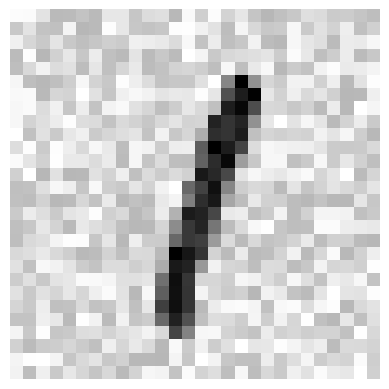

In [140]:
knn_clf.fit(X_train_mod, y_train_mod)
# comparing image with noise in it with its predicted "cleaned" image
some_image = X_test_mod[5]
plt.imshow(some_image.reshape(28,28), cmap="binary")
plt.axis("off")
plt.show()

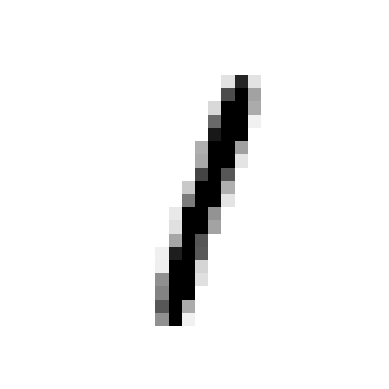

In [139]:
clean_digit = knn_clf.predict([some_image])
# plotting the "cleaned" image as predicted by KNN classifier
digit = clean_digit.reshape(28, 28)
plt.imshow(digit, cmap="binary")
plt.axis("off")
plt.show()

Donee!